# Deconvolving simulated data generated with linear functions

In [1]:
import torch
from time_deconv.time_deconv_simulator import *
from time_deconv.time_deconv import *

# Configure

In [2]:
device = torch.device("cuda:0")
dtype = torch.float32
dtype_np = np.float32

# Load data

In [3]:
bulk_anndata_path = "/home/nbarkas/disk2/deconvolution_method/datasets/ebov/load_data_python/ebov_bulk.h5ad"
sc_anndata_path = "/home/nbarkas/disk2/deconvolution_method/datasets/ebov/load_data_python/ebov_sc.h5ad"

In [4]:
with open(bulk_anndata_path, 'rb') as fh:
    bulk_anndata  = anndata.read_h5ad(fh)
with open(sc_anndata_path, 'rb') as fh:
    sc_anndata = anndata.read_h5ad(fh)

In [5]:
# select samples only after or on tp 0
bulk_anndata = bulk_anndata[bulk_anndata.obs['dpi_time'] >= 0,]

In [6]:
ebov_dataset = DeconvolutionDataset(
    sc_anndata = sc_anndata,
    sc_celltype_col = "Subclustering_reduced",
    bulk_anndata = bulk_anndata,
    bulk_time_col = "dpi_time",
    dtype_np = dtype_np,
    dtype = dtype,
    device=device,
    feature_selection_method = 'overdispersed_bulk_and_high_sc' #'overdispersed_bulk'
)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=3.1044e-10): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T


# Run Deconvolution

In [7]:
pseudo_time_reg_deconv = TimeRegularizedDeconvolution(
    dataset=ebov_dataset,
    polynomial_degree = 5,
    basis_functions = "polynomial",
    device=device,
    dtype=dtype)

In [8]:
pseudo_time_reg_deconv.fit_model(n_iters=5_001, verbose=True, log_frequency=1000)

[iteration: 0]   loss: 30368141.04
[iteration: 1000]   loss: 8949899.85
[iteration: 2000]   loss: 3629147.69
[iteration: 3000]   loss: 2064478.48
[iteration: 4000]   loss: 1487634.59
[iteration: 5000]   loss: 1227569.94


# Examine Outputs

<AxesSubplot:title={'center':'Losses'}, xlabel='iteration', ylabel='ELBO Loss'>

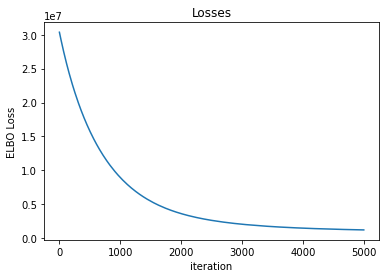

In [9]:
# plot the losses
pseudo_time_reg_deconv.plot_loss()

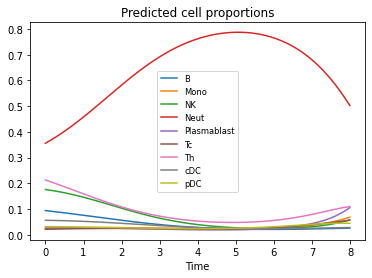

In [10]:
# calculate and plot composition trajectories
pseudo_time_reg_deconv.calculate_composition_trajectories(n_intervals = 1000)
pseudo_time_reg_deconv.plot_composition_trajectories()

<AxesSubplot:xlabel='$\\phi_g$', ylabel='Counts'>

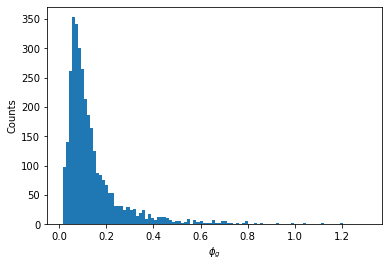

In [11]:
# examine the per-gene dispersions
pseudo_time_reg_deconv.plot_phi_g_distribution()

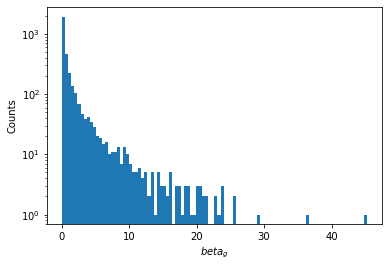

In [12]:
# examine the gene capture coefficients
pseudo_time_reg_deconv.plot_beta_g_distribution()
matplotlib.pyplot.yscale('log')

# Plot per sample deconvolution

In [25]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [28]:
from matplotlib.pyplot import cm

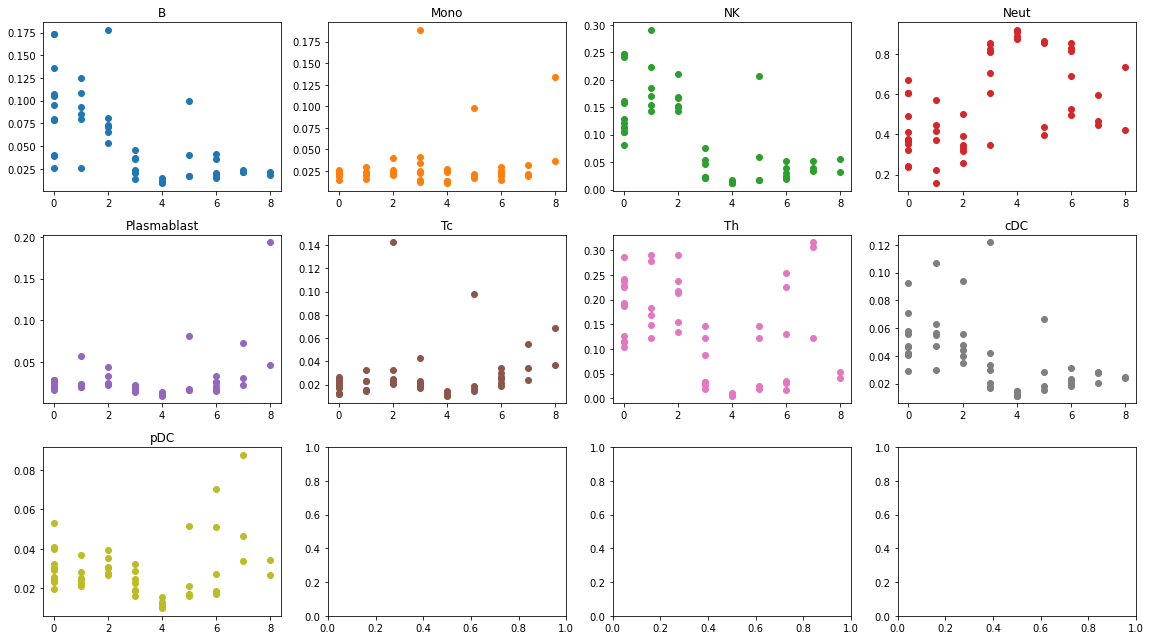

In [49]:
t_m = pseudo_time_reg_deconv.dataset.t_m.clone().detach().cpu()
cell_pop = pseudo_time_reg_deconv.param_store_hist[-1]['cell_pop_posterior_loc_mc'].clone().detach().cpu()
sort_order = torch.argsort(pseudo_time_reg_deconv.dataset.t_m)

fig, ax = matplotlib.pyplot.subplots(3, 4, figsize=(16,9))

for i in range(cell_pop.shape[1]):
    ax[i // 4, i % 4].scatter(
        t_m[sort_order].clone().detach().cpu() * 8,
        cell_pop[sort_order,i].clone().detach().cpu(),
        color = cm.tab10(i)
    )
    ax[i // 4, i % 4].set_title(pseudo_time_reg_deconv.dataset.cell_type_str_list[i])
    
matplotlib.pyplot.tight_layout()